In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from gholax.util.model import Model
import numpy as np

In [2]:
model = Model('../example_configs/example_shear_x_rsd.yaml')

In [3]:
#Make a model prediction at the reference parameter values
param_dict = model.prior.get_reference_point()
model_pred, state = model.predict_model('Nx2PTAngularPowerSpectrum',param_dict,return_state=True, apply_scale_mask=False)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


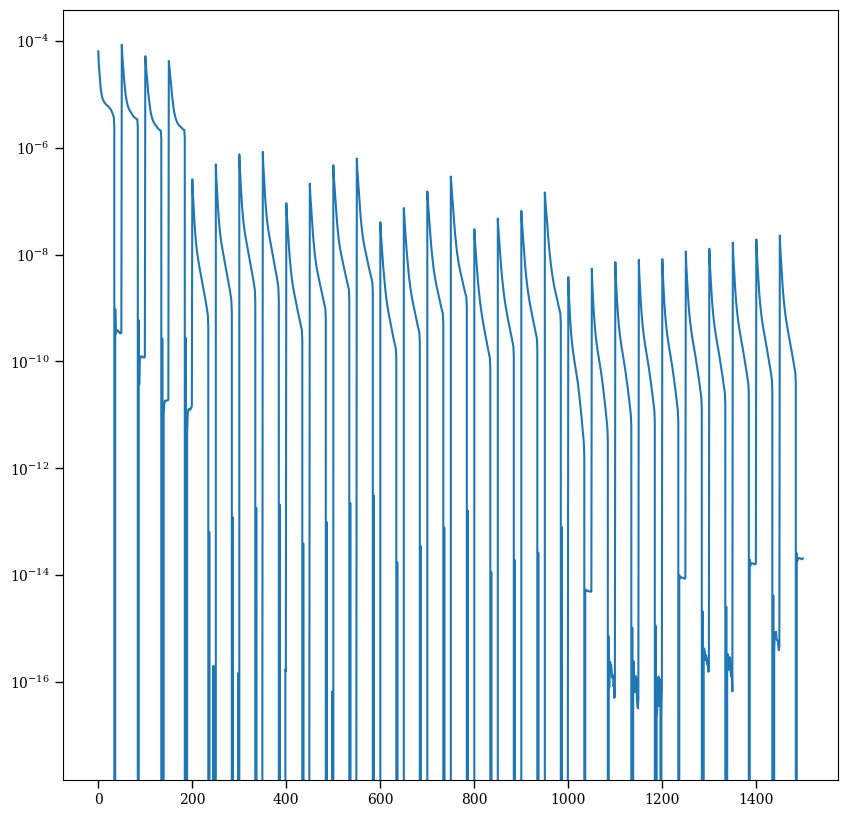

In [4]:
#The output prediction is a concatenation of many different redshift bins (and observables) in general
plt.semilogy(model_pred)
plt.gcf().set_size_inches((10,10))

In [5]:
# The ordering of the predictions is defined by the ordering of the
# obsered data vector, which is stored in the relevant likelihood
likelihood = model.likelihoods['Nx2PTAngularPowerSpectrum']
data_vector = likelihood.observed_data_vector

# spectrum_type specifies what type of spectrum each entry contains
# zbin0 and zbin1 specify the index of the bins of the two fields being correlated
# separation tells us the ell value (generically the radius/wavenumber
# value contains the measured value
print(data_vector.spectra.dtype)

[('spectrum_type', 'S10'), ('zbin0', '<i8'), ('zbin1', '<i8'), ('separation', '<f8'), ('value', '<f8')]


In [7]:
#lets use this information to write a plotting script
def plot_c_kk_vs_model(observed_spectra, model_pred, cov_data, scale_cuts, 
                      use_source_samples, spectrum_info, logy=False, ellcell=True, yscale=50):

    f, ax = plt.subplots(2*len(use_source_samples), len(use_source_samples), sharex=True, 
                         sharey='row', gridspec_kw={'height_ratios': [3, 1]*len(use_source_samples)})
    ell_eff = spectrum_info['c_kk']['separation']
    
    counter = 0
    for ii, i in enumerate(use_source_samples):
        for jj, j in enumerate(use_source_samples):
            if i>j: 
                ax[2*jj][ii].axis('off')
                ax[2*jj+1][ii].axis('off')
                continue
            idx = np.where((observed_spectra['spectrum_type'] == b'c_kk') & (observed_spectra['zbin0'] == i) & (observed_spectra['zbin1'] == j))[0]
            ell_eff_i = spectrum_info['c_kk']['separation']
            
            n_ell = len(ell_eff)
            idxx, idxy = np.meshgrid(idx, idx, indexing='ij')
            cov = np.diag(cov_data['value'][idxx, idxy])
            err = np.sqrt(cov)
            model = model_pred[idx]

            ax[2*jj,ii].errorbar(ell_eff_i,  ell_eff_i**ellcell * observed_spectra['value'][idx], ell_eff_i**ellcell * err, color=f'k', ls='', marker='o', ms=3, capsize=3)        
            ax[2*jj,ii].plot(ell_eff_i,  ell_eff_i**ellcell * model, color=f'k')
            
            ax[2*jj+1,ii].plot(ell_eff_i, (observed_spectra['value'][idx]-model)/err, color=f'k', ls='', marker='o', ms=3)
            ax[2*jj+1,ii].hlines(0, 1, ell_eff[-1], color='k')
            
            ax[2*jj, ii].fill_betweenx(np.linspace(-1, 1, 100), 0, scale_cuts['c_kk'][f'{i}_{j}'][0], color='k', alpha=0.2)
            ax[2*jj, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_kk'][f'{i}_{j}'][1], 3000, color='k', alpha=0.2)
            ax[2*jj+1, ii].fill_betweenx(np.linspace(-1, 1, 100), 0, scale_cuts['c_kk'][f'{i}_{j}'][0], color='k', alpha=0.4)              
            ax[2*jj+1, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_kk'][f'{i}_{j}'][0], scale_cuts['c_kk'][f'{i}_{j}'][1], color='k', alpha=0.2)
            ax[2*jj+1, ii].fill_betweenx(np.linspace(-1, 1, 100), scale_cuts['c_kk'][f'{i}_{j}'][1], 3000, color='k', alpha=0.4)
            ax[2*jj, ii].set_xlim([25, scale_cuts['c_kk'][f'{i}_{j}'][1]*1.5])
            ax[2*jj, ii].set_xscale('functionlog', functions=(lambda x: np.exp(3*np.sqrt(x)), lambda x: x**2))

            if ii==0:
                if not ellcell:
                    ax[2*jj,0].set_ylabel(r'$C_{\ell}^{\gamma_{E} \gamma_{E}}$')
                else:
                    ax[2*jj,0].set_ylabel(r'$\ell\,C_{\ell}^{\gamma_{E} \gamma_{E}}$')

            ax[2*jj][0].set_yscale('log')
            ax[2*jj][0].set_ylim([1e-9,5e-6])      

        ax[-1,ii].set_xlabel(r'$\ell$')     

    f.subplots_adjust(wspace=0.02, hspace=0.14)
    f.set_figheight(8)
    f.set_figwidth(12)

/tmp/ipykernel_553114/245753738.py:37: RuntimeWarning: overflow encountered in exp
  ax[2*jj, ii].set_xscale('functionlog', functions=(lambda x: np.exp(3*np.sqrt(x)), lambda x: x**2))


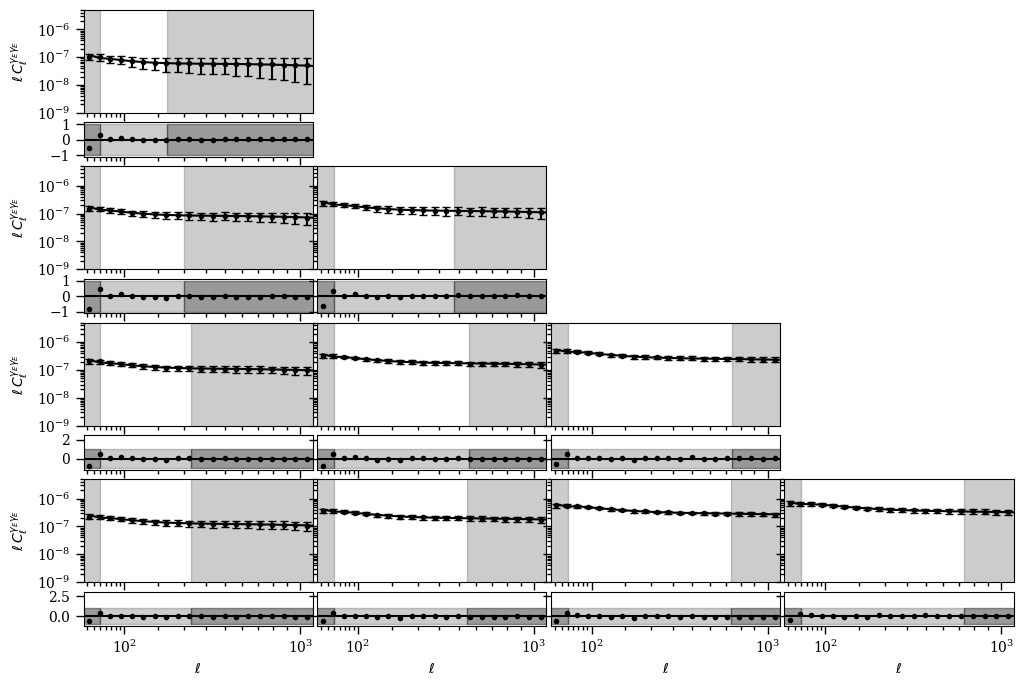

In [9]:
plot_c_kk_vs_model(data_vector.spectra, model_pred, data_vector.cov, data_vector.scale_cuts, 
                   [0,1,2,3], data_vector.spectrum_info)